In [1]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Import CIFAR10 dataset
# The CIFAR10 dataset contains 60,000 color images in 10 classes, with 6,000 images in each class. 
# The dataset is divided into 50,000 training images and 10,000 testing image

# The classes are:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# You can access the CIFAR10 directly from TensorFlow
# cifar10 = tf.keras.datasets.cifar10

(train_images, train_labels), (test_images, test_labels) = tf.compat.v1.keras.datasets.cifar10.load_data()
#(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

In [3]:
# Explore the data. The images are 32x32 numpy arrays, with pixel range from 0 to 255. 
# The last dimension is related to color channels, refers to (R,G,B).

print(train_images.shape)

(50000, 32, 32, 3)


In [4]:
# The labels are an array of integers, ranging from 0 to 9.
df = pd.DataFrame(class_names,columns=['Class'])
print(df)

        Class
0    airplane
1  automobile
2        bird
3         cat
4        deer
5         dog
6        frog
7       horse
8        ship
9       truck


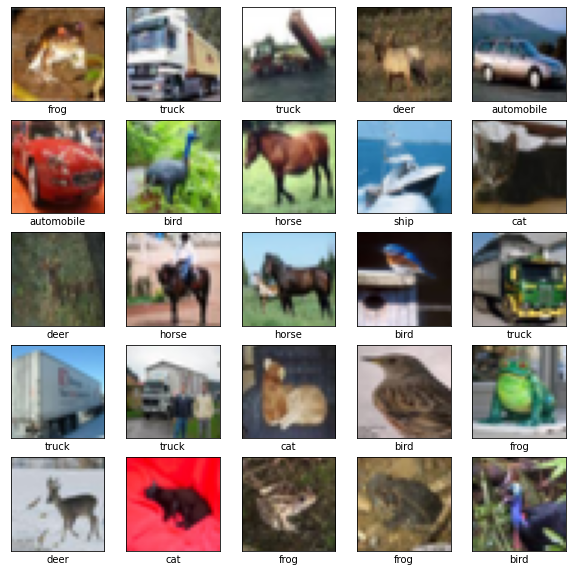

In [5]:
# First, we can visualize the CIFAR10 data
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()


In [15]:
# Now we create a cat_vs_dog dataset from Cifar10
class_names = ['cat', 'dog']

# Get from CIFAR10 the indexes for cats and dogs
idx_cats = np.argwhere(train_labels[:,0] == 3)
idx_dogs = np.argwhere(train_labels[:,0] == 5)

# Create the new dataset and change the labels: 1 for dogs and 0 for cats
# If you have kernel problems, reduce the training size
train_size = 10000

train_images_cats_dogs = np.zeros((train_size,32,32,3), dtype='uint8')
train_labels_cats_dogs = np.zeros((train_size,1))

train_images_cats_dogs[:train_size//2] = train_images[idx_cats[:train_size//2,0]]
train_images_cats_dogs[train_size//2:train_size] = train_images[idx_dogs[:train_size//2,0]]

train_labels_cats_dogs[:train_size//2] = tf.zeros_like(idx_cats[:train_size//2])
train_labels_cats_dogs[train_size//2:train_size] = tf.ones_like(idx_cats[:train_size//2])

train_images_cats_dogs = tf.convert_to_tensor(train_images_cats_dogs)

# Shuffle the train data before train
indices = tf.range(start=0, limit=tf.shape(train_images_cats_dogs)[0], dtype=tf.int32)
shuffled_indices = tf.random.shuffle(indices)

train_images_cats_dogs = tf.gather(train_images_cats_dogs, shuffled_indices)
train_labels_cats_dogs = tf.gather(train_labels_cats_dogs, shuffled_indices)

In [16]:
# We do the same for test dataset
idt_cats = np.argwhere(test_labels[:,0] == 3)
idt_dogs = np.argwhere(test_labels[:,0] == 5)

# If you have kernel problems, reduce the test size
test_size = 2000

test_images_cats_dogs = np.zeros((test_size,32,32,3), dtype='uint8')
test_labels_cats_dogs = np.zeros((test_size,1))

test_images_cats_dogs[:test_size//2] = test_images[idt_cats[:test_size//2,0]]
test_images_cats_dogs[test_size//2:test_size] = test_images[idt_dogs[:test_size//2,0]]

test_labels_cats_dogs[:test_size//2] = tf.zeros_like(idt_cats[:test_size//2])
test_labels_cats_dogs[test_size//2:test_size] = tf.ones_like(idt_cats[:test_size//2])

test_images_cats_dogs = tf.convert_to_tensor(test_images_cats_dogs)

# Shuffle the test data
indices = tf.range(start=0, limit=tf.shape(test_images_cats_dogs)[0], dtype=tf.int32)
shuffled_indices = tf.random.shuffle(indices)

test_images_cats_dogs = tf.gather(test_images_cats_dogs, shuffled_indices)
test_labels_cats_dogs = tf.gather(test_labels_cats_dogs, shuffled_indices)

# We can check the dimensions of the new dataset
print(train_images_cats_dogs.shape)
print(test_images_cats_dogs.shape)

(10000, 32, 32, 3)
(2000, 32, 32, 3)


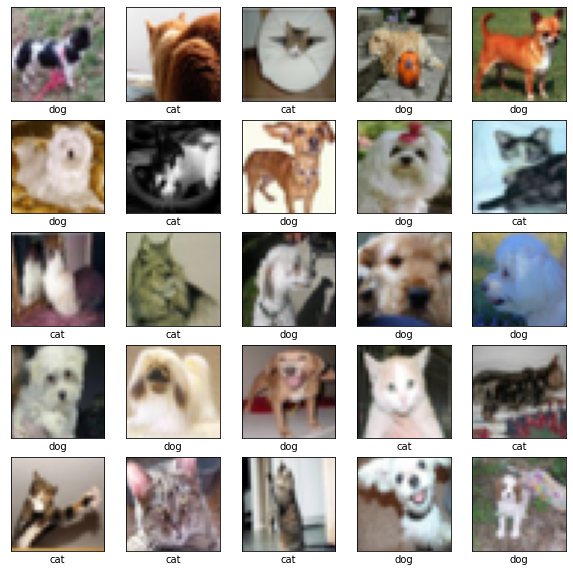

In [17]:
# Plot some pictures
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images_cats_dogs[i])
    plt.xlabel(class_names[train_labels_cats_dogs[i][0]])
plt.show()

In [18]:
# Preprocess the data: Normalize pixel values to be between 0 and 1
train_images_cats_dogs = train_images_cats_dogs / 255
test_images_cats_dogs = test_images_cats_dogs / 255

In [19]:
# Build the models using keras layers 
# (The basic building block of a neural network is the layer. 
# Layers extract representations from the data fed into them.)

# Fully-connected neural network
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(32, 32, 3)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2)
])

# Documentation: https://www.tensorflow.org/guide/keras/sequential_model


In [20]:
# Overview of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               393344    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 393,602
Trainable params: 393,602
Non-trainable params: 0
_________________________________________________________________


# Categorial-Cross entropy loss

It is the default loss function to use for multi-class classification problems where each class is assigned a unique integer value from 0 to (num_classes – 1). Computes the cross-entropy loss between true labels and predicted labels.

$Loss=-\sum_{i=1}^{N} y_i \cdot log \hat{y}_i$



## Compile the model
Before the model is ready for training, it needs a few more settings. These are added during the model's compile step:

+ Loss function - This measures how accurate the model is during training. You want to minimize this function to "steer" the model in the right direction.

+ Optimizer - This is how the model is updated based on the data it sees and its loss function.

+ Metrics - Used to monitor the training and testing steps. The following example uses accuracy, the fraction of the images that are correctly classified.

In [21]:
# Documentation: https://www.tensorflow.org/guide/keras/train_and_evaluate/

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Train the model


Training the neural network model requires the following steps:

+ Feed the training data to the model. 
+ The model learns to associate images and labels.
+ You ask the model to make predictions about a test set—in this example.
+ Verify that the predictions match the labels from the test labels.


In [23]:
history = model.fit(train_images_cats_dogs, train_labels_cats_dogs, 
                    epochs=20, 
                    validation_data=(test_images_cats_dogs, test_labels_cats_dogs))

Train on 10000 samples, validate on 2000 samples
Epoch 1/20
10000/10000 [==============================] - 1s 127us/sample - loss: 0.6209 - accuracy: 0.6484 - val_loss: 0.6686 - val_accuracy: 0.6005
Epoch 2/20
10000/10000 [==============================] - 1s 128us/sample - loss: 0.6180 - accuracy: 0.6451 - val_loss: 0.6596 - val_accuracy: 0.6050
Epoch 3/20
10000/10000 [==============================] - 1s 130us/sample - loss: 0.6141 - accuracy: 0.6529 - val_loss: 0.6664 - val_accuracy: 0.6110
Epoch 4/20
10000/10000 [==============================] - 1s 132us/sample - loss: 0.6133 - accuracy: 0.6480 - val_loss: 0.6668 - val_accuracy: 0.6130
Epoch 5/20
10000/10000 [==============================] - 1s 132us/sample - loss: 0.6140 - accuracy: 0.6462 - val_loss: 0.6676 - val_accuracy: 0.5925
Epoch 6/20
10000/10000 [==============================] - 1s 134us/sample - loss: 0.6065 - accuracy: 0.6560 - val_loss: 0.6616 - val_accuracy: 0.6145
Epoch 7/20
10000/10000 [===========================

2000/1 - 0s - loss: 0.6642 - accuracy: 0.6120
test loss: 0.6783879537582398
test accuracy: 0.612


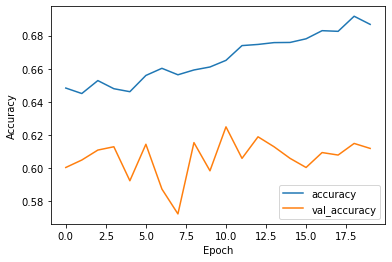

In [24]:
# Evaluate the model

plt.figure()
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images_cats_dogs,  test_labels_cats_dogs, verbose=2)

print('test loss:', test_loss)
print('test accuracy:', test_acc)


## Make Predictions
With the model trained, you can use it to make predictions about some images. 

In [25]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
predictions = probability_model.predict(test_images_cats_dogs)

def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i][0], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i][0]
  plt.grid(False)
  plt.xticks(range(len(class_names)))
  plt.yticks([])
  thisplot = plt.bar(range(len(class_names)), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

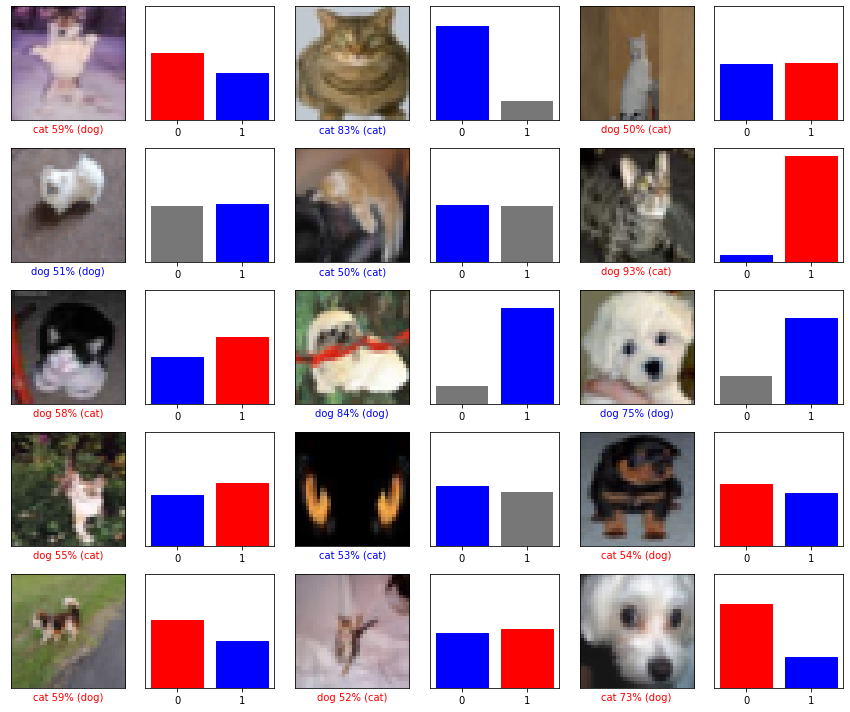

In [26]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels_cats_dogs, test_images_cats_dogs)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels_cats_dogs)
plt.tight_layout()
plt.show()

## To do:

1 - Repeat the problem, but now try to construct a model to classify trucks and automobiles from the CIFAR10 dataset. How good is the model? The accuracy is better than for the cats and dogs dataset? If yes, why?

2 - Try a more sophisticated model such as a convolutional neural network. How this new model performs? Does the accuracy improve?

3 - How the convolutional neural network model performs for a multi-class classification? Use all classes available from CIFAR10 to construct the model.

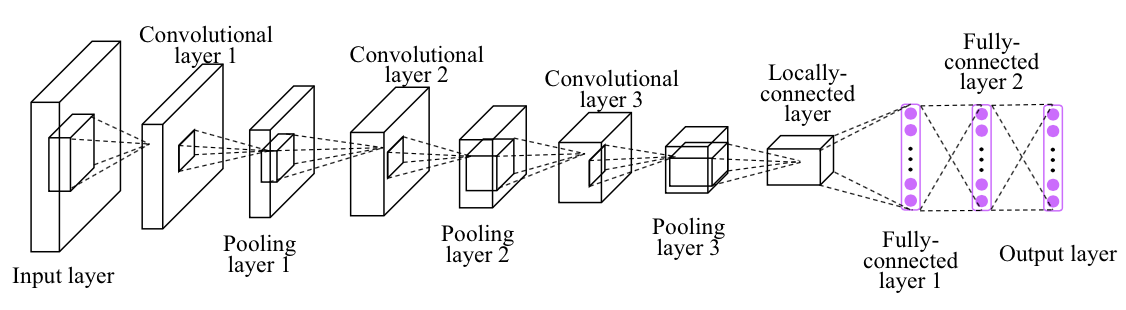
